## Setup and Data Loading


In [ ]:
# Install required libraries (run once)
# !pip install umap-learn hdbscan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings("ignore")

np.random.seed(42)
sns.set_style(style="whitegrid")

# Load data
df = pd.read_csv("Analytica.csv")

OCEAN = {
    "EXT": "Extraversion",
    "EST": "Neuroticism",
    "AGR": "Agreeableness",
    "CSN": "Conscientiousness",
    "OPN": "Openness",
}
dimensions = list(OCEAN.keys())

print(f"Dataset shape: {df.shape}")
print(
    f"Target available: {df['target'].notna().sum()} / {len(df)} ({df['target'].notna().mean()*100:.1f}%)"
)
df.head()

Dataset shape: (34163, 112)
Target available: 5096 / 34163 (14.9%)


,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,EXT_time,EST,EST_time,AGR,AGR_time,CSN,CSN_time,OPN,OPN_time,target
0,3.0,2.0,2.0,4.0,4.0,4.0,5.0,3.0,1.0,3.0,...,72.625,0.44,46.155,0.24,82.665,0.10,62.022,0.10,40.415,NaN
1,3.0,4.0,1.0,4.0,3.0,2.0,2.0,4.0,3.0,5.0,...,45.790,0.42,36.420,-0.14,86.422,0.10,56.401,0.26,38.205,0.0
2,3.0,3.0,4.0,4.0,5.0,3.0,3.0,5.0,2.0,2.0,...,64.250,0.42,50.268,0.50,58.487,0.18,44.737,0.34,51.454,NaN
3,1.0,5.0,1.0,5.0,2.0,4.0,1.0,5.0,3.0,5.0,...,50.384,0.64,59.489,0.22,59.080,0.18,66.815,0.32,58.911,NaN
4,1.0,4.0,3.0,5.0,1.0,2.0,2.0,4.0,2.0,4.0,...,59.927,0.46,39.848,0.40,97.554,0.24,45.858,0.42,48.390,0.0


In [2]:
# Prepare features
X = df.drop(columns=["target"])
y = df["target"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature matrix shape: {X_scaled.shape}")

Feature matrix shape: (34163, 111)


## Baseline: PCA + K-Means

First, let's establish the baseline with the original approach to compare against.


In [3]:
# Baseline: PCA + KMeans
pca_baseline = PCA(n_components=6)
X_pca_baseline = pca_baseline.fit_transform(X_scaled)

kmeans_baseline = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_baseline = kmeans_baseline.fit_predict(X_pca_baseline)

sil_baseline = silhouette_score(X_pca_baseline, labels_baseline)
print(f"Baseline (PCA + K-Means) Silhouette Score: {sil_baseline:.4f}")
print(f"Explained variance: {pca_baseline.explained_variance_ratio_.sum()*100:.1f}%")

Baseline (PCA + K-Means) Silhouette Score: 0.1386
Explained variance: 34.6%


---

## Approach 1: UMAP + HDBSCAN

**UMAP** (Uniform Manifold Approximation and Projection) preserves local manifold structure, unlike PCA's linear approach.

**HDBSCAN** (Hierarchical Density-Based Spatial Clustering) automatically finds the number of clusters and can label outliers as noise.


In [4]:
import umap
import hdbscan

# UMAP for dimensionality reduction
# n_neighbors: controls local vs global structure (higher = more global)
# min_dist: minimum distance between points in embedding
# n_components: embedding dimensions

reducer = umap.UMAP(
    n_components=10,  # Higher than 2 for clustering (2 is for visualization)
    n_neighbors=30,  # Balance local/global structure
    min_dist=0.0,  # Allow tight clusters
    metric="euclidean",
    random_state=42,
)

print("Fitting UMAP...")
X_umap = reducer.fit_transform(X_scaled)
print(f"UMAP embedding shape: {X_umap.shape}")

Fitting UMAP...
UMAP embedding shape: (34163, 10)
UMAP embedding shape: (34163, 10)


In [5]:
# HDBSCAN clustering
# min_cluster_size: minimum size for a cluster
# min_samples: how conservative the clustering is

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=200,  # Minimum cluster size (tune based on data)
    min_samples=15,  # More conservative clustering
    cluster_selection_method="eom",  # Excess of Mass (good for varying densities)
    prediction_data=True,
)

labels_hdbscan = clusterer.fit_predict(X_umap)

# Count clusters (excluding noise labeled as -1)
n_clusters = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)
n_noise = (labels_hdbscan == -1).sum()

print(f"\nHDBSCAN Results:")
print(f"  Number of clusters found: {n_clusters}")
print(f"  Noise points: {n_noise} ({n_noise/len(labels_hdbscan)*100:.1f}%)")

# Calculate silhouette (excluding noise points)
mask = labels_hdbscan != -1
if mask.sum() > 0 and n_clusters > 1:
    sil_hdbscan = silhouette_score(X_umap[mask], labels_hdbscan[mask])
    print(f"  Silhouette Score (excl. noise): {sil_hdbscan:.4f}")
else:
    sil_hdbscan = -1
    print("  Cannot compute silhouette (not enough clusters)")

# Cluster distribution
print(f"\nCluster distribution:")
for label in sorted(set(labels_hdbscan)):
    count = (labels_hdbscan == label).sum()
    label_name = "Noise" if label == -1 else f"Cluster {label}"
    print(f"  {label_name}: {count} samples ({count/len(labels_hdbscan)*100:.1f}%)")


HDBSCAN Results:
  Number of clusters found: 4
  Noise points: 6112 (17.9%)
  Silhouette Score (excl. noise): 0.0562

Cluster distribution:
  Noise: 6112 samples (17.9%)
  Cluster 0: 385 samples (1.1%)
  Cluster 1: 382 samples (1.1%)
  Cluster 2: 412 samples (1.2%)
  Cluster 3: 26872 samples (78.7%)
  Silhouette Score (excl. noise): 0.0562

Cluster distribution:
  Noise: 6112 samples (17.9%)
  Cluster 0: 385 samples (1.1%)
  Cluster 1: 382 samples (1.1%)
  Cluster 2: 412 samples (1.2%)
  Cluster 3: 26872 samples (78.7%)


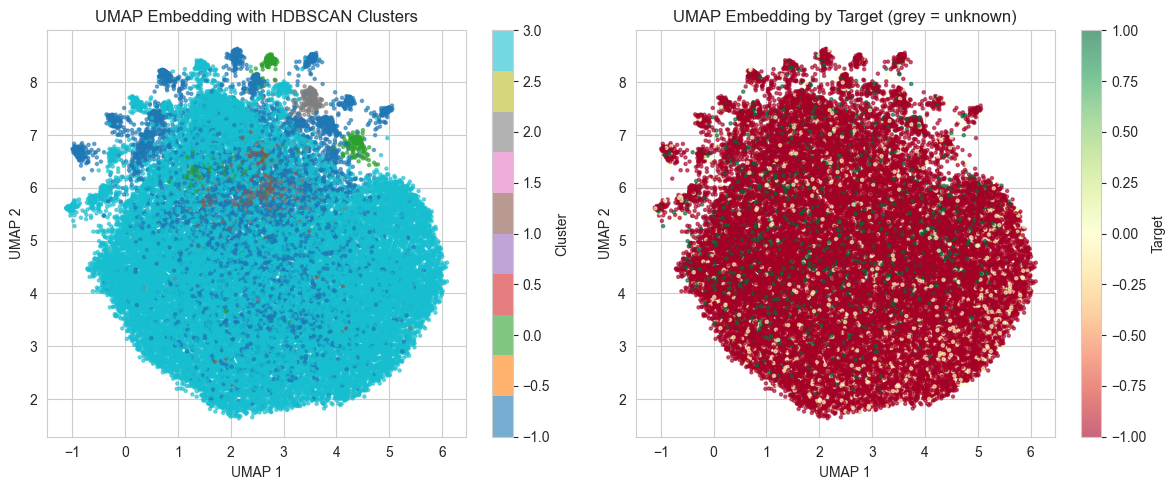

In [6]:
# Visualize UMAP embedding (2D projection)
reducer_2d = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap_2d = reducer_2d.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

# Plot by HDBSCAN clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(
    X_umap_2d[:, 0], X_umap_2d[:, 1], c=labels_hdbscan, cmap="tab10", s=5, alpha=0.6
)
plt.colorbar(scatter, label="Cluster")
plt.title("UMAP Embedding with HDBSCAN Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Plot by target (where available)
plt.subplot(1, 2, 2)
colors = y.fillna(-1).values
scatter = plt.scatter(
    X_umap_2d[:, 0], X_umap_2d[:, 1], c=colors, cmap="RdYlGn", s=5, alpha=0.6
)
plt.colorbar(scatter, label="Target")
plt.title("UMAP Embedding by Target (grey = unknown)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

plt.tight_layout()
plt.show()

---

## Approach 2: Gaussian Mixture Models (GMM)

GMM provides **soft clustering** - probability of belonging to each cluster, not just hard assignments.
This is useful for weighted label propagation.


In [7]:
# Use PCA first (GMM works better with reduced dimensions)
pca_gmm = PCA(n_components=20)
X_pca_gmm = pca_gmm.fit_transform(X_scaled)

print(
    f"Explained variance with 20 components: {pca_gmm.explained_variance_ratio_.sum()*100:.1f}%"
)

Explained variance with 20 components: 49.9%


Optimal number of components (BIC): 9


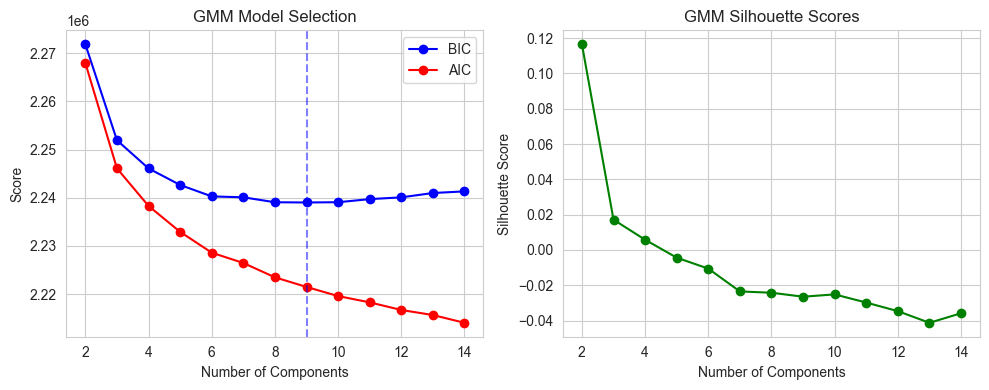

In [8]:
# Find optimal number of components using BIC
n_components_range = range(2, 15)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(
        n_components=n, covariance_type="full", random_state=42, n_init=5
    )
    gmm.fit(X_pca_gmm)
    bic_scores.append(gmm.bic(X_pca_gmm))
    aic_scores.append(gmm.aic(X_pca_gmm))

# Plot BIC/AIC
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, "b-o", label="BIC")
plt.plot(n_components_range, aic_scores, "r-o", label="AIC")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.title("GMM Model Selection")
plt.legend()
plt.axvline(
    n_components_range[np.argmin(bic_scores)], color="b", linestyle="--", alpha=0.5
)

optimal_n = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components (BIC): {optimal_n}")

plt.subplot(1, 2, 2)
# Silhouette scores for different n
sil_scores = []
for n in n_components_range:
    gmm = GaussianMixture(
        n_components=n, covariance_type="full", random_state=42, n_init=5
    )
    labels = gmm.fit_predict(X_pca_gmm)
    sil_scores.append(silhouette_score(X_pca_gmm, labels))

plt.plot(n_components_range, sil_scores, "g-o")
plt.xlabel("Number of Components")
plt.ylabel("Silhouette Score")
plt.title("GMM Silhouette Scores")

plt.tight_layout()
plt.show()

In [9]:
# Train GMM with optimal components
gmm = GaussianMixture(
    n_components=optimal_n,
    covariance_type="full",  # Full covariance matrix (allows elliptical clusters)
    n_init=10,
    random_state=42,
)


labels_gmm = gmm.fit_predict(X_pca_gmm)
cluster_probs = gmm.predict_proba(X_pca_gmm)  # Soft assignments!

sil_gmm = silhouette_score(X_pca_gmm, labels_gmm)
print(f"GMM Silhouette Score: {sil_gmm:.4f}")
print(f"\nCluster distribution:")
for i in range(optimal_n):
    count = (labels_gmm == i).sum()
    print(f"  Cluster {i}: {count} samples ({count/len(labels_gmm)*100:.1f}%)")

GMM Silhouette Score: -0.0263

Cluster distribution:
  Cluster 0: 3943 samples (11.5%)
  Cluster 1: 4788 samples (14.0%)
  Cluster 2: 5122 samples (15.0%)
  Cluster 3: 2884 samples (8.4%)
  Cluster 4: 3105 samples (9.1%)
  Cluster 5: 3426 samples (10.0%)
  Cluster 6: 4600 samples (13.5%)
  Cluster 7: 3891 samples (11.4%)
  Cluster 8: 2404 samples (7.0%)


---

## Approach 3: Spectral Clustering

Spectral clustering uses graph connectivity (similarity-based) and can find non-convex clusters.


In [ ]:
# Spectral clustering (use PCA-reduced data for computational efficiency)
# Note: Spectral clustering is O(n^3), so we use fewer samples or PCA

pca_spectral = PCA(n_components=15)
X_pca_spectral = pca_spectral.fit_transform(X_scaled)

# Test different n_clusters
spectral_sil_scores = []
n_clusters_range = range(2, 10)

print("Testing Spectral Clustering (this may take a moment)...")
for n in n_clusters_range:
    spectral = SpectralClustering(
        n_clusters=n,
        affinity="nearest_neighbors",
        n_neighbors=15,
        random_state=42,
        n_jobs=-1,
    )
    labels = spectral.fit_predict(X_pca_spectral)
    sil = silhouette_score(X_pca_spectral, labels)
    spectral_sil_scores.append(sil)
    print(f"  n_clusters={n}: Silhouette = {sil:.4f}")

optimal_spectral_n = n_clusters_range[np.argmax(spectral_sil_scores)]
print(f"\nOptimal number of clusters: {optimal_spectral_n}")

Testing Spectral Clustering (this may take a moment)...


In [ ]:
# Train Spectral Clustering with optimal n
spectral = SpectralClustering(
    n_clusters=optimal_spectral_n,
    affinity="nearest_neighbors",
    n_neighbors=15,
    random_state=42,
    n_jobs=-1,
)

labels_spectral = spectral.fit_predict(X_pca_spectral)
sil_spectral = silhouette_score(X_pca_spectral, labels_spectral)

print(f"Spectral Clustering Silhouette Score: {sil_spectral:.4f}")
print(f"\nCluster distribution:")
for i in range(optimal_spectral_n):
    count = (labels_spectral == i).sum()
    print(f"  Cluster {i}: {count} samples ({count/len(labels_spectral)*100:.1f}%)")

---

## Comparison of Methods


In [ ]:
# Summary comparison
results = pd.DataFrame(
    {
        "Method": [
            "PCA + K-Means (Baseline)",
            "UMAP + HDBSCAN",
            "PCA + GMM",
            "PCA + Spectral",
        ],
        "Silhouette Score": [sil_baseline, sil_hdbscan, sil_gmm, sil_spectral],
        "N Clusters": [5, n_clusters, optimal_n, optimal_spectral_n],
    }
)

print("=" * 60)
print("CLUSTERING METHOD COMPARISON")
print("=" * 60)
print(results.to_string(index=False))
print("=" * 60)

# Plot comparison
plt.figure(figsize=(10, 5))
colors = ["#ff7f0e", "#2ca02c", "#1f77b4", "#9467bd"]
bars = plt.bar(results["Method"], results["Silhouette Score"], color=colors)
plt.ylabel("Silhouette Score")
plt.title("Clustering Method Comparison")
plt.xticks(rotation=15)
plt.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
for bar, score in zip(bars, results["Silhouette Score"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{score:.3f}",
        ha="center",
        va="bottom",
        fontsize=11,
    )
plt.tight_layout()
plt.show()

---

## Generate Predictions

We'll use the best performing method to generate predictions for the Kaggle competition.


In [ ]:
# Determine best method
best_idx = results["Silhouette Score"].idxmax()
best_method = results.loc[best_idx, "Method"]
print(f"Best method: {best_method}")

# Use appropriate labels based on best method
if "HDBSCAN" in best_method:
    best_labels = labels_hdbscan
elif "GMM" in best_method:
    best_labels = labels_gmm
elif "Spectral" in best_method:
    best_labels = labels_spectral
else:
    best_labels = labels_baseline

In [ ]:
# Generate predictions using cluster-based label propagation

# Method 1: Hard clustering prediction
study = df[["ID", "target"]].copy()
study["Cluster"] = best_labels

# Calculate average target per cluster (using labeled data only)
cluster_means = study.groupby("Cluster")["target"].mean().reset_index()
cluster_means.columns = ["Cluster", "Average"]

print("Cluster target averages:")
print(cluster_means)

# Merge and predict
study = study.merge(cluster_means, on="Cluster")

# Handle noise points for HDBSCAN (cluster = -1)
if -1 in best_labels:
    # For noise points, use overall average
    overall_avg = y.dropna().mean()
    study.loc[study["Cluster"] == -1, "Average"] = overall_avg
    print(f"\nNoise points assigned overall average: {overall_avg:.3f}")

# Filter to unknown targets only
study_unknown = study[study["target"].isna()].copy()
study_unknown["prediction"] = (study_unknown["Average"] > 0.5).astype(int)

answer_hard = study_unknown[["ID", "prediction"]]
print(f"\nPredictions generated: {len(answer_hard)}")
print(
    f"Predicted positive: {answer_hard['prediction'].sum()} ({answer_hard['prediction'].mean()*100:.1f}%)"
)

In [ ]:
# Method 2: Soft clustering prediction (GMM only)
# Uses probability-weighted target averages

if "GMM" in best_method or True:  # Always compute for comparison
    # Get cluster probabilities for each sample
    study_soft = df[["ID", "target"]].copy()

    # Calculate average target per cluster
    labeled_mask = y.notna()
    cluster_targets = []

    for c in range(optimal_n):
        # Weighted average of targets for this cluster
        weights = cluster_probs[labeled_mask, c]
        targets = y[labeled_mask].values
        if weights.sum() > 0:
            weighted_avg = (weights * targets).sum() / weights.sum()
        else:
            weighted_avg = 0.5  # Default
        cluster_targets.append(weighted_avg)

    cluster_targets = np.array(cluster_targets)
    print("GMM cluster weighted target averages:")
    for i, avg in enumerate(cluster_targets):
        print(f"  Cluster {i}: {avg:.3f}")

    # Predict using probability-weighted cluster targets
    predicted_probs = cluster_probs @ cluster_targets
    study_soft["predicted_prob"] = predicted_probs

    # Filter to unknown targets
    study_soft_unknown = study_soft[study_soft["target"].isna()].copy()
    study_soft_unknown["prediction"] = (
        study_soft_unknown["predicted_prob"] > 0.5
    ).astype(int)

    answer_soft = study_soft_unknown[["ID", "prediction"]]
    print(f"\nSoft predictions generated: {len(answer_soft)}")
    print(
        f"Predicted positive: {answer_soft['prediction'].sum()} ({answer_soft['prediction'].mean()*100:.1f}%)"
    )

---

## Save Submissions


In [ ]:
# Save hard clustering submission
answer_hard.to_csv("submit_alternative_hard.csv", index=False)
print("Saved: submit_alternative_hard.csv")

# Save soft clustering submission (GMM)
answer_soft.to_csv("submit_alternative_soft.csv", index=False)
print("Saved: submit_alternative_soft.csv")

print("\nSubmit these files to Kaggle to compare results!")

---

## UMAP Parameter Tuning (Optional)

Explore how UMAP parameters affect clustering quality.


In [ ]:
# Parameter grid search for UMAP + HDBSCAN
print("UMAP + HDBSCAN Parameter Tuning")
print("=" * 50)

param_results = []

for n_neighbors in [15, 30, 50]:
    for n_components in [5, 10, 15]:
        for min_cluster_size in [100, 200, 300]:
            try:
                reducer = umap.UMAP(
                    n_components=n_components,
                    n_neighbors=n_neighbors,
                    min_dist=0.0,
                    random_state=42,
                )
                X_emb = reducer.fit_transform(X_scaled)

                clusterer = hdbscan.HDBSCAN(
                    min_cluster_size=min_cluster_size, min_samples=10
                )
                labels = clusterer.fit_predict(X_emb)

                n_clust = len(set(labels)) - (1 if -1 in labels else 0)
                noise_pct = (labels == -1).sum() / len(labels) * 100

                if n_clust > 1:
                    mask = labels != -1
                    sil = silhouette_score(X_emb[mask], labels[mask])
                else:
                    sil = -1

                param_results.append(
                    {
                        "n_neighbors": n_neighbors,
                        "n_components": n_components,
                        "min_cluster_size": min_cluster_size,
                        "n_clusters": n_clust,
                        "noise_pct": noise_pct,
                        "silhouette": sil,
                    }
                )
            except Exception as e:
                print(
                    f"Error with params {n_neighbors}, {n_components}, {min_cluster_size}: {e}"
                )

param_df = pd.DataFrame(param_results)
param_df = param_df.sort_values("silhouette", ascending=False)
print("\nTop 10 Parameter Combinations:")
print(param_df.head(10).to_string(index=False))

In [ ]:
# Use best parameters to generate final prediction
if len(param_df) > 0:
    best_params = param_df.iloc[0]
    print(f"Best parameters:")
    print(f"  n_neighbors: {best_params['n_neighbors']}")
    print(f"  n_components: {best_params['n_components']}")
    print(f"  min_cluster_size: {best_params['min_cluster_size']}")
    print(f"  Silhouette: {best_params['silhouette']:.4f}")
    print(f"  N clusters: {best_params['n_clusters']}")
    print(f"  Noise %: {best_params['noise_pct']:.1f}%")

    # Retrain with best params
    reducer_best = umap.UMAP(
        n_components=int(best_params["n_components"]),
        n_neighbors=int(best_params["n_neighbors"]),
        min_dist=0.0,
        random_state=42,
    )
    X_best = reducer_best.fit_transform(X_scaled)

    clusterer_best = hdbscan.HDBSCAN(
        min_cluster_size=int(best_params["min_cluster_size"]), min_samples=10
    )
    labels_best = clusterer_best.fit_predict(X_best)

    # Generate predictions with tuned model
    study_tuned = df[["ID", "target"]].copy()
    study_tuned["Cluster"] = labels_best

    cluster_means_tuned = study_tuned.groupby("Cluster")["target"].mean().reset_index()
    cluster_means_tuned.columns = ["Cluster", "Average"]

    study_tuned = study_tuned.merge(cluster_means_tuned, on="Cluster")

    # Handle noise
    if -1 in labels_best:
        overall_avg = y.dropna().mean()
        study_tuned.loc[study_tuned["Cluster"] == -1, "Average"] = overall_avg

    study_tuned_unknown = study_tuned[study_tuned["target"].isna()].copy()
    study_tuned_unknown["prediction"] = (study_tuned_unknown["Average"] > 0.5).astype(
        int
    )

    answer_tuned = study_tuned_unknown[["ID", "prediction"]]
    answer_tuned.to_csv("submit_tuned_umap_hdbscan.csv", index=False)
    print(f"\nSaved: submit_tuned_umap_hdbscan.csv")
    print(
        f"Predicted positive: {answer_tuned['prediction'].sum()} ({answer_tuned['prediction'].mean()*100:.1f}%)"
    )